# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [505]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt

# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two rules of thumb about the `display` argument:
* When doing development, turn the display on (`display=True`).
* When collecting data or saving a video, turn the display off (`display=False`).

If you are having trouble with the in-browser display — e.g., if it is running slowly on your laptop — then you can try the pybullet display instead (`display=False` and `display_pybullet=True`).

The `seed` argument (an integer, default `None`) initializes the random number generator that is used by the simulator.

In [506]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=True,
    seed=None,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7038/static/


Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`
* `camera_catview()`

In [520]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently. This function will be called 25 times per second (i.e., at 25 Hz) by the simulator.

In [508]:
class Controller:
    def __init__(self, A, B, C, K, L, dt = 0.04):
        # FIXME: add class variable names to this list (e.g., 'xhat')
        # if you want these variables to be logged by the simulator
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.dt = dt
        self.xhat = np.zeros(6)

    
    def reset(self):
        pass
    
    def run(self, t, star_measurements):
        """
        The variable t is the current time.

        The variable star_measurements is a 1d array of length twice the
        number N of stars:

            [y_1, z_1, y_2, z_2, ..., y_N, z_N]
        
        The image coordinates y_i and z_i of the i'th star (for i = 1, ..., N)
        are at index 2 * i - 2 and 2 * i - 1 of this array, respectively.
        """
        y = star_measurements

        y_hat = self.C @ self.xhat

        u = -self.K @ self.xhat

        dxhat = self.A @ self.xhat + self.B @ u + self.L @ (y - y_hat)

        self.xhat += dxhat * self.dt 
        
        torque_1, torque_2, torque_3, torque_4 = u*5
        #print(u)
        
        return torque_1, torque_2, torque_3, torque_4

Create an instance of the controller.

In [509]:

A = [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -0.0, 0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
B = [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-0.018530635807362836, 0.037061271614725715, -0.018530635807362836, -2.62041779934909e-18], [-0.032096002714907576, -4.538696765530462e-18, 0.032096002714907576, 0.0], [-0.0249042741960589, -0.0249042741960589, -0.0249042741960589, 0.0498085483921178]]
C = [[-2.625, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, 0.0, 0.0, 0.0, 0.0], [-2.73286481605181, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, -0.532113843210265, 0.0, 0.0, 0.0], [-2.73286481605181, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, 0.532113843210265, 0.0, 0.0, 0.0], [-2.625, 0.0, 0.532113843210265, 0.0, 0.0, 0.0], [0.0, 2.73286481605181, 0.0, 0.0, 0.0, 0.0], [-2.625, 0.0, -0.532113843210265, 0.0, 0.0, 0.0], [0.0, 2.73286481605181, 0.0, 0.0, 0.0, 0.0]]
K = [[-53.452248382494325, -99.9999999999928, -57.7350269189569, -260.20226285034806, -450.68353950118285, -240.32496346081507], [-53.45224838248462, 6.688527301584614e-14, 115.47005383791335, 520.404525700669, -5.7637937725309585e-12, -240.32496346078705], [-53.45224838249501, 99.99999999999707, -57.73502691896572, -260.2022628503676, 450.6835395012053, -240.32496346082942], [106.90449676498262, -2.9072314439285088e-12, 6.248907712182382e-12, 3.149058068299774e-11, -1.114193059685972e-11, 480.64992692162105]]

L = [[-0.9876478342819631, -8.948473874330144e-18, -0.9582161284289047, -5.055533765670522e-17, -0.9876478342819631, -1.7371719464287865e-16, -0.9486658651252523, -9.508582449357386e-17, -0.9486658651252521, -9.508582449357386e-17], [9.508582449357386e-17, 0.9294857431523277, 9.225228614098385e-17, 0.941241221412845, 9.508582449357386e-17, 0.9760390023727071, 0.0232766296101898, 0.9919126729831327, -0.02327662961018962, 0.9919126729831327], [4.2311494572064616e-16, -1.2367047057910696, 4.105062058518078e-16, -0.5541357761577508, 4.2311494572064616e-16, 1.466359143488545, 1.3515319246398076, 0.1195456252635415, -1.351531924639807, 0.1195456252635415], [4.25774995909397e-16, -0.8970044000975113, 4.130869870825432e-16, -0.4040667435068137, 4.25774995909397e-16, 1.0550943574517395, 0.9760493787746258, 0.08229304423323835, -0.9760493787746249, 0.08229304423323835], [-3.5245439946336823e-16, 0.8651840689445809, -3.4195132959214863e-16, 0.8732763273634325, -3.5245439946336823e-16, 0.897230489813426, 0.016023210434422244, 0.9174172836051872, -0.016023210434422924, 0.9174172836051872], [-0.9141548754389255, 3.496094284418342e-16, -0.8869132449060967, 2.6564903133040555e-16, -0.9141548754389255, 1.7115076076597332e-17, -0.8780736368416427, 1.908968563014199e-16, -0.8780736368416425, 1.908968563014199e-16]]

A = np.array(A)
B = np.array(B)
C = np.array(C)
K = np.array(K)
L = np.array(L)

controller = Controller(A,B,C,K,L)

You could reset the simulator with given initial conditions.

In [510]:
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.1,
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.0,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=False,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Or, you could reset the simulator with initial conditions sampled at random (in particular, each initial condition will be sampled from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.1$).

In [511]:
if True:
    simulator.reset(
        initial_conditions=None,
        scope_noise=0.0,        # <-- standard deviation of each image coordinate of each star tracker measurement
        space_debris=True,      # <-- whether or not there is space debris
        docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
    )

Reset the controller.

In [512]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

If you create a video (i.e., if `video_filename` is not `None`), then — by default — the size of that video will be 640x480 pixels. You can change the size of the video by calling the following function **before** you call `simulator.run`:

```python
simulator.set_snapshot_size(
    320, # <-- width (example)
    240, # <-- height (example)
)
```

Both the width and height must be multiples of 16. One reason why you might want to change the size is to reduce the time it takes to create a video — a smaller size will take less time (but will be lower resolution). Another reason why you might want to change the size is to get a different aspect ratio — a square video, in particular, might be more appropriate if you wanted to use `camera_scopeview`, since the image captured by the star tracker is square.

In [513]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=60.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

Check if the space-cat has docked.

In [514]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat docked.


Get, show, and save a snapshot of the simulation after the last time step.

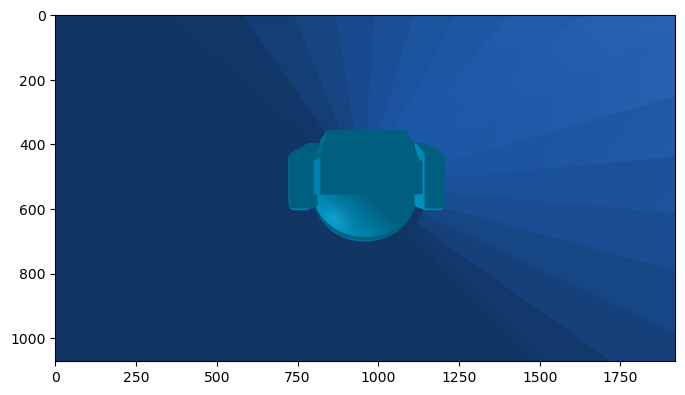

In [515]:
# Set the width and height of the snapshot (must be multiples of 16)
simulator.set_snapshot_size(
    640, # <-- width
    480, # <-- height
)

# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

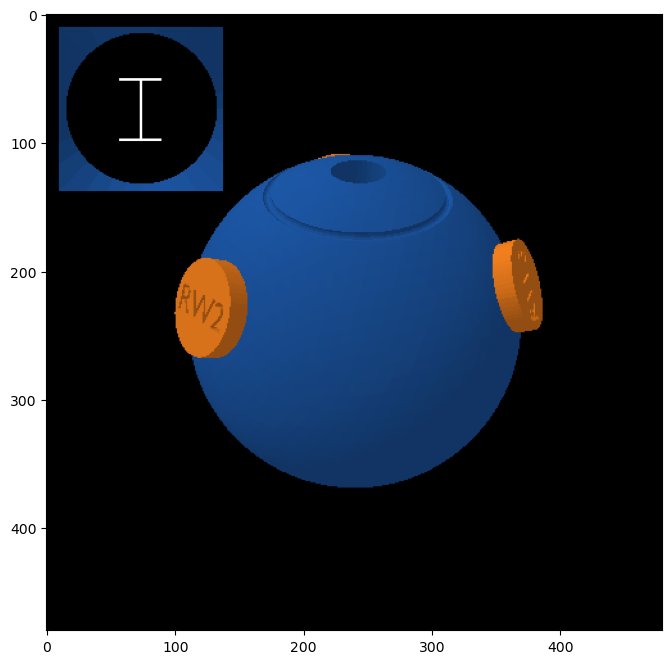

In [516]:
# Get snapshot as height x width x 4 numpy array of RGBA values
# with a picture-in-picture view of the scope
rgba = simulator.pybullet_snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results. (This code is meant only for development. You will want to create different and better plots for your own report.)

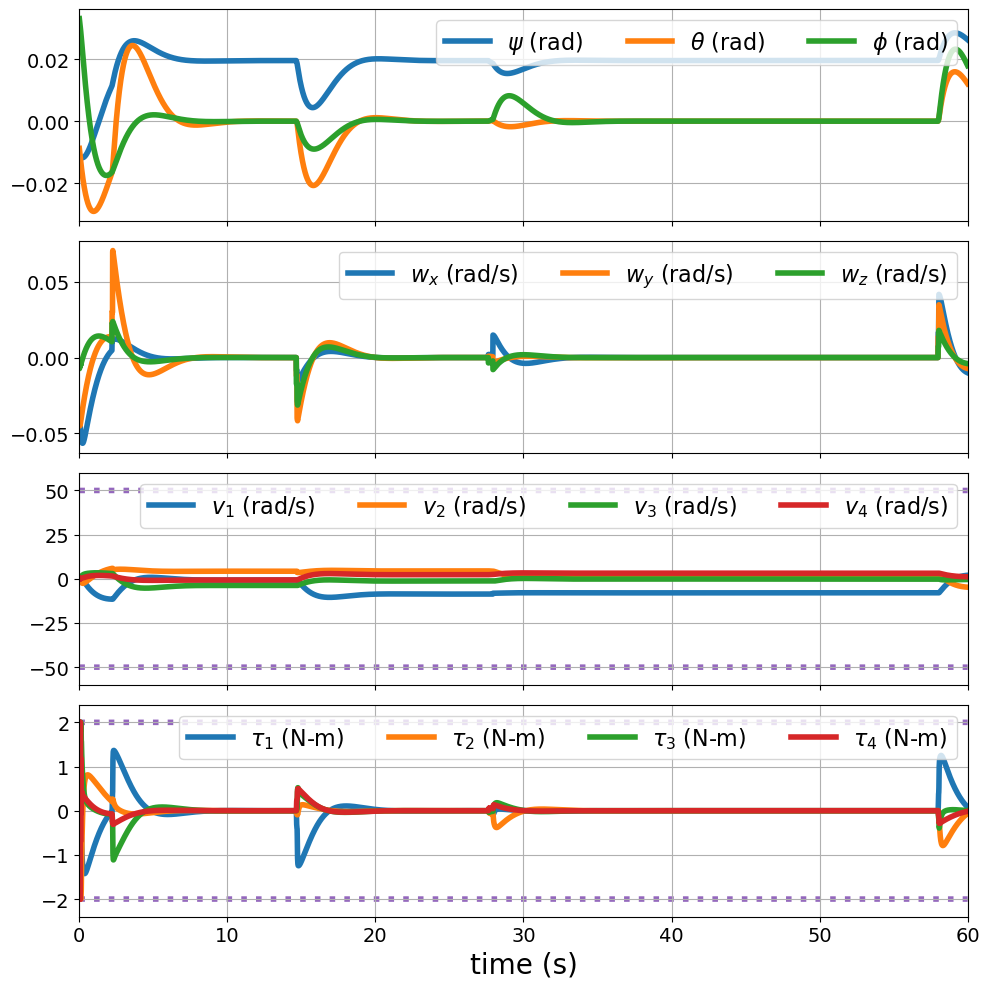

In [517]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [518]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

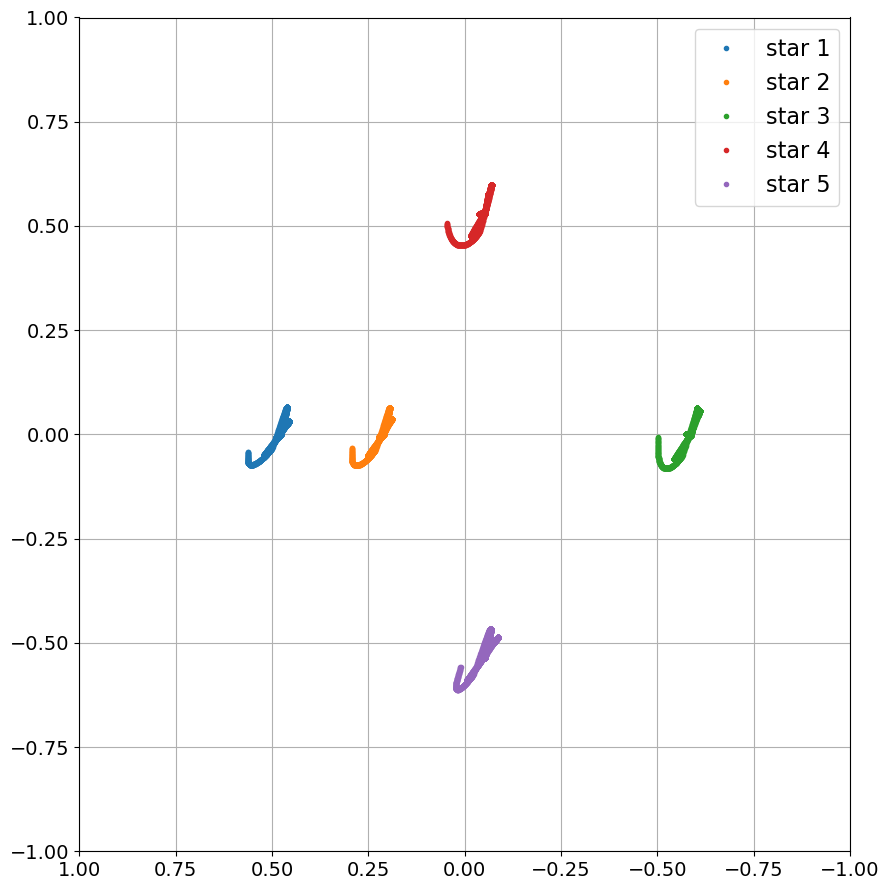

In [519]:
# Create a figure with one subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Scatter-plot the position of all stars at all time steps in the scope
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(y, z, label=f'star {i + 1}', linestyle='none', marker='.', markersize=6)

# Change appearance of axes
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(1., -1.) # <-- the "y_star" axis points left (not right)
ax.set_ylim(-1., 1.) # <-- the "z_star" axis points up

# Make the arrangement of subplots look nice
fig.tight_layout()

In [521]:
num_simulations = 100
successful_landings = 0
failed_landings = 0

for i in range(num_simulations):
    simulator.reset(
        initial_conditions=None,
        scope_noise=0.0,        # <-- standard deviation of each image coordinate of each star tracker measurement
        space_debris=True,      # <-- whether or not there is space debris
        docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
    )
    
    controller.reset()  # Reset controller
    
    # Run simulation
    data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=60.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)
    
    # Check if the aircraft has landed
    if simulator.has_docked():
        successful_landings += 1
    else:
        failed_landings += 1

KeyboardInterrupt: 

In [ ]:
labels = ['Successful Landings', 'Failed Landings']
sizes = [successful_landings, failed_landings]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90,textprops={'fontsize': 14})
plt.title('Zagi Aircraft Landing Outcomes',fontsize=16)
plt.show()